In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import operator
import unicodedata
import string
from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
# import xgboost as xgb
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import confusion_matrix

from string import digits

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import NMF

from src.Cleaning import *
from src.Modelling import *
from src.Cleaning2 import *

## Declaring all functions

In [2]:
def w_freq(text_series):
    countvect = CountVectorizer()
    bag_of_words = countvect.fit_transform(text_series)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in countvect.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [3]:
df = pd.read_csv('sephora_review_db.csv.zip')

## Model 1

### Predicting skin type based on review text and description using Logistic Regression

In [5]:
df3 = df[['review_text', 'description', 'skin_type']]
df3.head()

,review_text,description,skin_type
0,Really good foundation I like it a lot but som...,"What it is: A soft-matte, long-wear foundation...",oily
1,"As someone who is very VERY fair, I have alway...","What it is: A soft-matte, long-wear foundation...",combination
2,First purchase of a foundation of any kind. Wa...,"What it is: A soft-matte, long-wear foundation...",combination
3,I absolutely love this foundation! I get compl...,"What it is: A soft-matte, long-wear foundation...",combination
4,Love this foundation! I was using Too Faced Bo...,"What it is: A soft-matte, long-wear foundation...",combination


In [6]:
# select all of skin types that are not oily, dry, normal
df3_others = df3[df3['skin_type'] != 'combination']
df3_others.shape

(33242, 3)

In [7]:
# select random sample of 3000 combination datapoints. Data is imbalanced
df3_combo = df3[df3['skin_type'] == 'combination']
combo_sample = df3.sample(n=20000)
combo_sample.shape

(20000, 3)

In [8]:
#combine other skintypes and combo random sample dfs
model_df = pd.concat([df3_others, combo_sample])
model_df.shape

(53242, 3)

In [9]:
# reformat strings for modelling for review text column
clean.format_strings(model_df, 'review_text', WordNetLemmatizer())

In [10]:
# reformat strings for modelling for description column
clean.format_strings(model_df, 'description', WordNetLemmatizer())

In [11]:
model_df = model_df.reset_index(drop=True)
model_df.index

RangeIndex(start=0, stop=53242, step=1)

In [12]:
tv = TfidfVectorizer()
tfidf = tv.fit_transform(model_df['review_text']).todense()
tfidf.shape

(53242, 22214)

In [13]:
bow = tv.get_feature_names()
review_nlp = pd.DataFrame(tfidf, columns=bow)
review_nlp.head()

,aa,aaaaaamazing,aaaaall,aaaalways,aaahhhhhh,aaand,aabsolutely,aannddddd,ab,aback,...,zonee,zoneextremely,zonethis,zoo,zoom,ztone,zumba,zyrtec,zzone,zzzzs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
tv2 = TfidfVectorizer()
tfidf2 = tv2.fit_transform(model_df['description']).todense()
tfidf2.shape

(53242, 2517)

In [15]:
bow2 = tv2.get_feature_names()
desc_nlp = pd.DataFrame(tfidf2, columns=bow2)
desc_nlp.head()

,ability,able,absorb,absorbent,absorbs,absorption,abyssinica,acacia,accompanying,according,...,youngerlooking,youre,youth,youthboosting,youthful,youthfullooking,youthfully,youve,zero,zinc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
final = pd.concat([review_nlp, desc_nlp], axis=1)
final.head()

,aa,aaaaaamazing,aaaaall,aaaalways,aaahhhhhh,aaand,aabsolutely,aannddddd,ab,aback,...,youngerlooking,youre,youth,youthboosting,youthful,youthfullooking,youthfully,youve,zero,zinc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
final2 = pd.concat([model_df, final], axis=1)
final2.drop(columns=['review_text', 'description'], inplace=True)
final2.head()

,skin_type,aa,aaaaaamazing,aaaaall,aaaalways,aaahhhhhh,aaand,aabsolutely,aannddddd,ab,...,youngerlooking,youre,youth,youthboosting,youthful,youthfullooking,youthfully,youve,zero,zinc
0,oily,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,oily,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,oily,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,oily,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,oily,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
final2.shape

(53242, 24841)

In [60]:
# instantiate X and y for models
y = final2.pop('skin_type')
X = final2.values

In [63]:
model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [64]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [65]:
precision = precision_score(y_test, y_pred, average=None)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average=None)

In [66]:
print(precision, accuracy, recall)

[0.32397004 0.50278087 0.37552565 0.53575419] 0.47900232890090905 [0.13505074 0.60769024 0.31454738 0.68647101]


In [67]:
probs=model.predict_proba(X_test)[:, 1]

In [81]:
# function to convert y_test to threshold
def convert_y_test_for_threshdf (y_test):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
#     return y_test
    return lb.classes_

In [82]:
convert_y_test_for_threshdf(y_test)

array(['combination', 'dry', 'normal', 'oily'], dtype='<U11')

In [70]:
convert_y_test_for_threshdf(y_test)[:, 0].shape

(13311,)

In [71]:
probs.shape

(13311,)

In [72]:
combo_thresh = calculate_threshold_values(probs, convert_y_test_for_threshdf(y_test)[:, 0])
dry_thresh = calculate_threshold_values(probs, convert_y_test_for_threshdf(y_test)[:, 1])
normal_thresh = calculate_threshold_values(probs, convert_y_test_for_threshdf(y_test)[:, 2])
oily_thresh = calculate_threshold_values(probs, convert_y_test_for_threshdf(y_test)[:, 3])

In [83]:
### DO NOT USE, SHOULD NOT USE ROC CURVE FOR MULTICLASSES ##

# fig, ax = plt.subplots(figsize=(10,7))
# ax.plot([0,1],[0,1], 'k', label="random")
# ax.set_title('ROC Curve - Logistic Regression', fontweight='bold', fontsize=24)

# plt.gca().set_color_cycle(['purple', 'blue', 'green', 'indigo'])


# plot_roc(ax, combo_thresh, 'Combination Skin ROC')
# plot_roc(ax, dry_thresh, 'Dry Skin ROC')
# plot_roc(ax, normal_thresh, 'Normal Skin ROC')
# plot_roc(ax, oily_thresh, 'Oily Skin ROC')

# plt.tight_layout()
# plt.savefig('imgs/logistic_regression.png')

In [74]:
# function created to evaluate AUC ROC score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [75]:
multiclass_roc_auc_score(y_test, y_pred)

0.6285527086259728

Looking at the confusion matrix below, the model does the best job predicting oily and dry skin (looking at the diagonal values under columns 2 and 4). While the model had a difficult time predicting normal and combination skin. Based on the below, creating a model trying to distinguish between oily and dry might be better.

In [76]:
confusion_matrix(y_test, y_pred)

array([[ 346,  766,  461,  989],
       [ 229, 2260,  542,  688],
       [ 255,  875,  893,  816],
       [ 238,  594,  482, 2877]])

In [105]:
### DO NOT USE, SHOULD NOT USE PRECISION RECALL CURVE FOR MULTICLASSES ##

# fig, ax = plt.subplots(figsize=(10,7))
# ax.set_title('Precision Recall Curves - Logistic Regression', fontweight='bold', fontsize=24)

# plt.gca().set_color_cycle(['purple', 'blue', 'green', 'indigo'])


# plot_precision_recall(ax, combo_thresh, 'Combination Skin')
# plot_precision_recall(ax, dry_thresh, 'Dry Skin')
# plot_precision_recall(ax, normal_thresh, 'Normal Skin')
# plot_precision_recall(ax, oily_thresh, 'Oily Skin')

# plt.tight_layout()
# plt.savefig('imgs/precision_recall_logistic.png')

In [6]:
# create wordcloud
def create_wordcloud(df, col_name):
    text = ' '.join(review for review in df[col_name])
    wordcloud = WordCloud(background_color='white').generate(text)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')

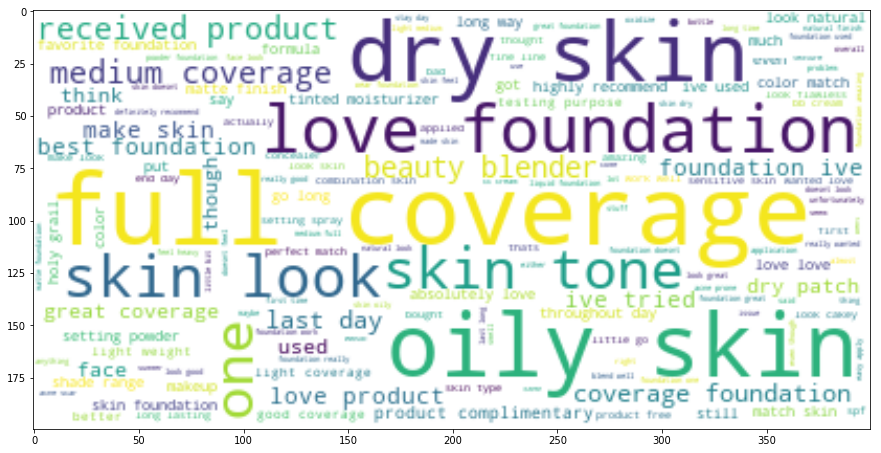

In [79]:
create_wordcloud(model_df, 'review_text')
plt.savefig('imgs/WordCloud_reviews')

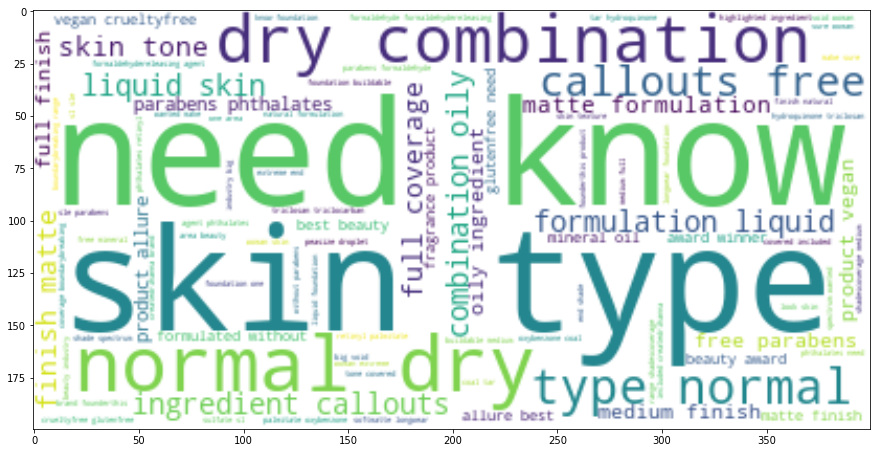

In [80]:
create_wordcloud(model_df, 'description')
plt.savefig('imgs/WordCloud_description')

## Model 2

### Predicting dry/oily skin type based on review text using multiple models

In [3]:
model2 = df[['review_text', 'skin_type']].copy()
model2.head()

,review_text,skin_type
0,Really good foundation I like it a lot but som...,oily
1,"As someone who is very VERY fair, I have alway...",combination
2,First purchase of a foundation of any kind. Wa...,combination
3,I absolutely love this foundation! I get compl...,combination
4,Love this foundation! I was using Too Faced Bo...,combination


In [4]:
model2 = model2[(model2['skin_type'] == 'oily') | (model2['skin_type'] == 'dry')]

In [5]:
model2 = cleaning(model2)
model2.head()

,review_text,skin_type
0,Really good foundation I like it a lot but som...,1
6,Let me say first that you need time to apply t...,1
12,This has to be the BEST foundation I have ever...,1
13,There aren’t many mainstream brands that cater...,1
17,Best foundation I have ever used and I get so ...,1


In [6]:
# format strings in review text column, lemmatize, lowercase, remove stop words
format_strings(model2, 'review_text', WordNetLemmatizer())
model2.head()

,review_text,skin_type
0,really good foundation like lot sometimes grab...,1
6,let say first need time apply foundation pract...,1
12,best foundation ever used blotted mid day rema...,1
13,arent many mainstream brand cater skin tone kn...,1
17,best foundation ever used get many compliment ...,1


In [16]:
model_list = [LogisticRegression(), GradientBoostingClassifier(), RandomForestClassifier(), DecisionTreeClassifier()]

In [12]:
def modelling(text_series, y, vectorizer, model):
    # declare X
    X = vectorizer.fit_transform(text_series)
    
    if model.__class__.__name__ == 'GaussianNB':
        X = X.toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    probs = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probs)
    thresh_df = calculate_threshold_values(probs, y_test)
    
    return precision, accuracy, recall, thresh_df, roc_auc, model

In [13]:
# plot multiple rocs for NLP
def plot_multiple_rocs(model_list, text_series, y, vectorizer):
    ax.plot([0,1],[0,1], 'k', label="random")
    for model in model_list:
        results = modelling(text_series, y, vectorizer, model)
        auc_score = results[4]
        plot_roc(ax, results[3], '{} AUC {}'.format(model.__class__.__name__, round(auc_score, 3)))

In [14]:
def plot_roc(ax, df, name):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label=name)
#     ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)
#     ax.set_title('ROC Curve - Model Comparison', fontweight='bold', fontsize=24)
    ax.legend(fontsize=14)

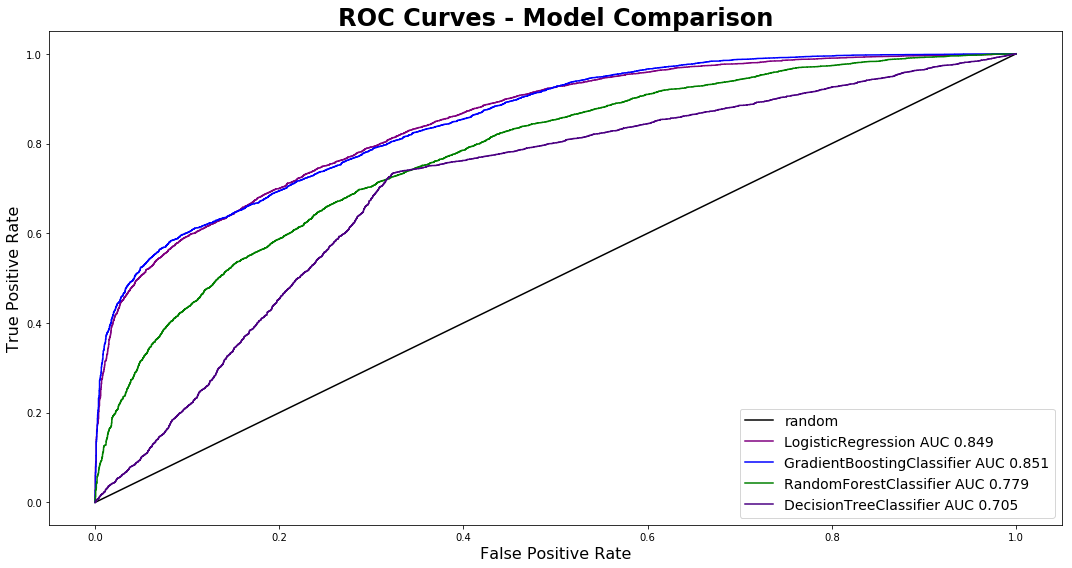

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('ROC Curves - Model Comparison', fontweight='bold', fontsize=24)


plt.gca().set_color_cycle(['purple', 'blue', 'green', 'indigo'])
plot_multiple_rocs(model_list, model2['review_text'], model2['skin_type'], TfidfVectorizer())
plt.tight_layout()
plt.savefig('imgs/model_compare_roc.png')

**Based on the below, it looks like the precision, accuracy, and recall for Gradient Boosting Classifier is around the same across all categories. Will use Logistic Regression and investigate to see if the model can be improved.**

In [12]:
def print_precision_acc_recall(df, text_series, y, model, vectorizer):
    print('Precision for {} is {:.2f}'.format(modelling(df[text_series], y, vectorizer, model)[5].__class__.__name__,
                                                modelling(df[text_series], y, vectorizer, model)[0]))
    print('Accuracy for {} is {:.2f}'.format(modelling(df[text_series], y, vectorizer, model)[5].__class__.__name__,
                                                modelling(df[text_series], y, vectorizer, model)[1]))
    print('Recall for {} is {:.2f}'.format(modelling(df[text_series], y, vectorizer, model)[5].__class__.__name__,
                                                modelling(df[text_series], y, vectorizer, model)[2]))

In [13]:
print_precision_acc_recall(model2, 'review_text', model2['skin_type'], LogisticRegression(), TfidfVectorizer())

Precision for LogisticRegression is 0.77
Accuracy for LogisticRegression is 0.75
Recall for LogisticRegression is 0.78


In [86]:
print_precision_acc_recall(model2, 'review_text', model2['skin_type'], GradientBoostingClassifier(), TfidfVectorizer())

Precision for GradientBoostingClassifier is 0.78
Accuracy for GradientBoostingClassifier is 0.71
Recall for GradientBoostingClassifier is 0.62


In [14]:
get_conf_matrix(model2['review_text'], model2['skin_type'], TfidfVectorizer(), LogisticRegression())

[[3748 1522]
 [1394 4858]]


In [88]:
get_conf_matrix(model2['review_text'], model2['skin_type'], TfidfVectorizer(), GradientBoostingClassifier())

[[2265  584]
 [1242 2027]]


In [102]:
log_model = modelling(model2['review_text'], model2['skin_type'], TfidfVectorizer(), LogisticRegression())
gb_model = modelling(model2['review_text'], model2['skin_type'], TfidfVectorizer(), GradientBoostingClassifier())

In [15]:
def plot_precision_recall(ax, df, name):
    ax.plot(df.tpr,df.precision, label=name)
#     ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('Recall', fontsize=16)
    ax.set_ylabel('Precision', fontsize=16)
#     ax.set_title('Precision/Recall Curve')
    ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
#     ax.set_title('ROC Curve - Model Comparison', fontweight='bold', fontsize=24)
    ax.set_xlim(xmin=0,xmax=1)
    ax.set_ylim(ymin=0,ymax=1)
    ax.legend(fontsize=14)

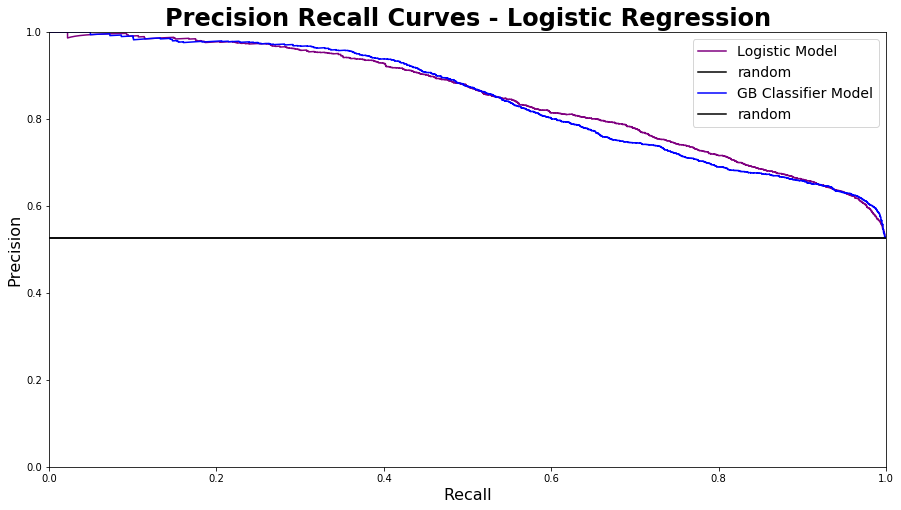

In [110]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('Precision Recall Curves - Logistic Regression', fontweight='bold', fontsize=24)

plt.gca().set_color_cycle(['purple', 'blue'])


plot_precision_recall(ax, logistic_model[3], 'Logistic Model')
plot_precision_recall(ax, gb_model[3], 'GB Classifier Model')

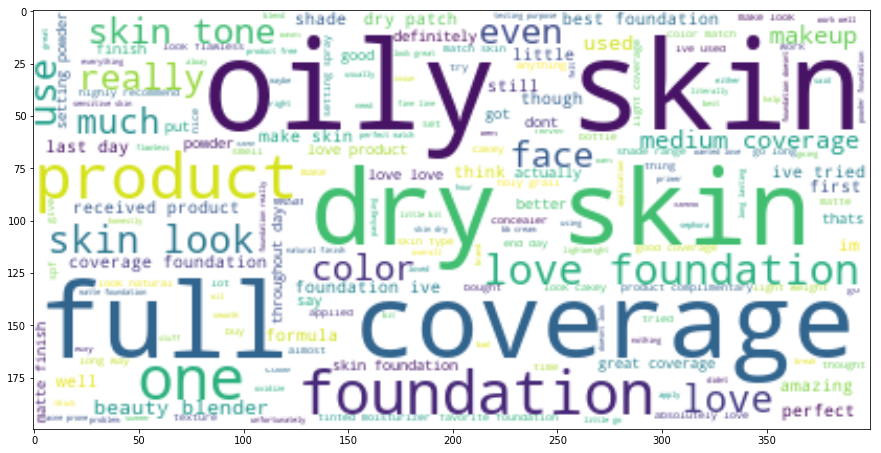

In [114]:
create_wordcloud(model2, 'review_text')
plt.savefig('imgs/WordCloud_reviews')

In [94]:
word_freq = w_freq(model2['review_text'])

word_lst = []
word_count = []
for row in word_freq:
    word_lst.append(row[0])
    word_count.append(row[1])
word_lst[:10], word_count[:10]

(['foundation',
  'skin',
  'coverage',
  'look',
  'love',
  'product',
  'like',
  'dry',
  'oily',
  'day'],
 [30886, 26593, 13452, 10579, 10400, 10365, 9561, 8460, 8068, 7258])

<BarContainer object of 10 artists>

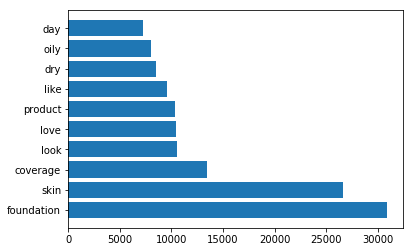

In [151]:
fig, ax = plt.subplots()
ax.barh(word_lst[:10], word_count[:10])

# Model 2

### Predicting dry/oily skin type based on review text using Ngrams of 1 or 2

Re-perform models to see if ngrams signicantly improves the performance of any of these models

In [115]:
model_list = [LogisticRegression(), GradientBoostingClassifier(), RandomForestClassifier(), DecisionTreeClassifier()]

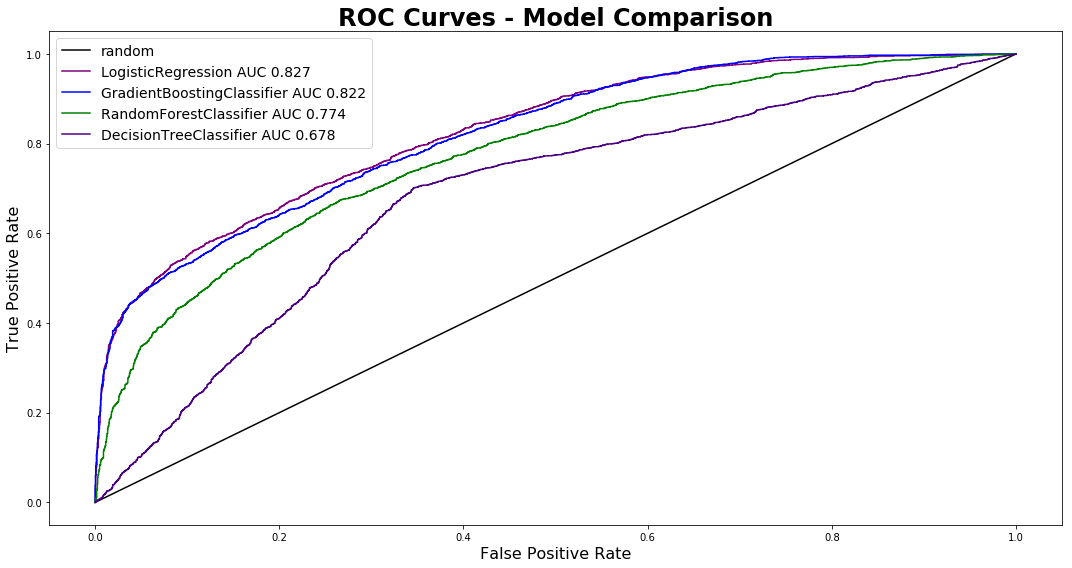

In [118]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('ROC Curves - Model Comparison', fontweight='bold', fontsize=24)


plt.gca().set_color_cycle(['purple', 'blue', 'green', 'indigo'])
plot_multiple_rocs(model_list, model2['review_text'], model2['skin_type'], TfidfVectorizer(ngram_range=(1,2)))
plt.tight_layout()
plt.savefig('imgs/model_compare_roc_ng2.png')

Creating an n-grams of 1 or 2 improves my models slightly. The AUC of Logistic Regression goes from 81% to 83%, while the AUC of my Gradient Boosting Classifier remains constant at 82%.

# Model 3

### Predicting dry/oily skin type based on review text removing words: foundation, skin, oily, dry

In [5]:
model3 = df[['review_text', 'skin_type']].copy()
model3 = model3[(model3['skin_type'] == 'oily') | (model3['skin_type'] == 'dry')]
model3 = cleaning2(model3)
format_strings2(model3, 'review_text', WordNetLemmatizer())
model3.head()

,review_text,skin_type
0,really good like lot sometimes grab patch kind...,1
6,let say first need time apply practice make pe...,1
12,best ever used blotted mid day remained matte ...,1
13,arent many mainstream brand cater tone know pe...,1
17,best ever used get many compliment light weigh...,1


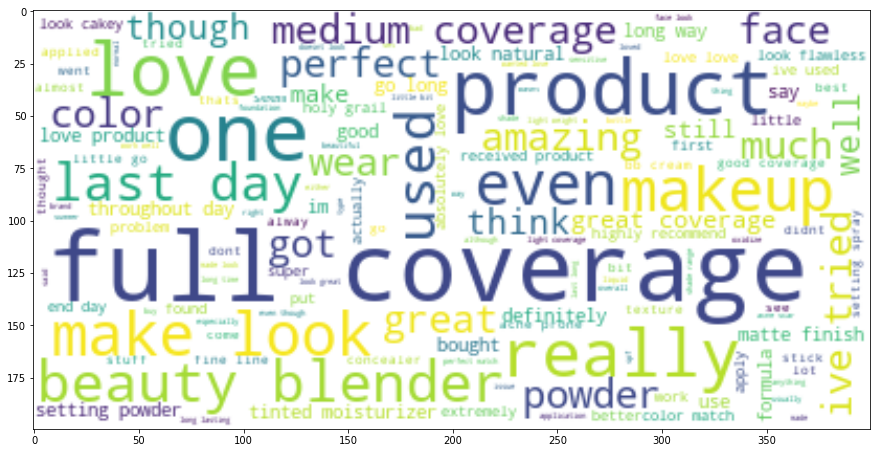

In [8]:
create_wordcloud(model3, 'review_text')
# plt.savefig('imgs/WordCloud_description')

In [10]:
word_freq = w_freq(model3['review_text'])

word_lst = []
word_count = []
for row in word_freq:
    word_lst.append(row[0])
    word_count.append(row[1])

<BarContainer object of 10 artists>

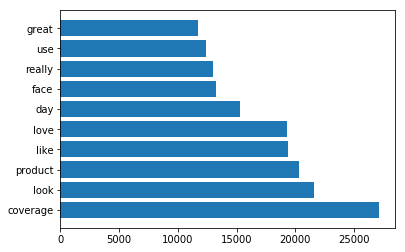

In [11]:
fig, ax = plt.subplots()
ax.barh(word_lst[:10], word_count[:10])

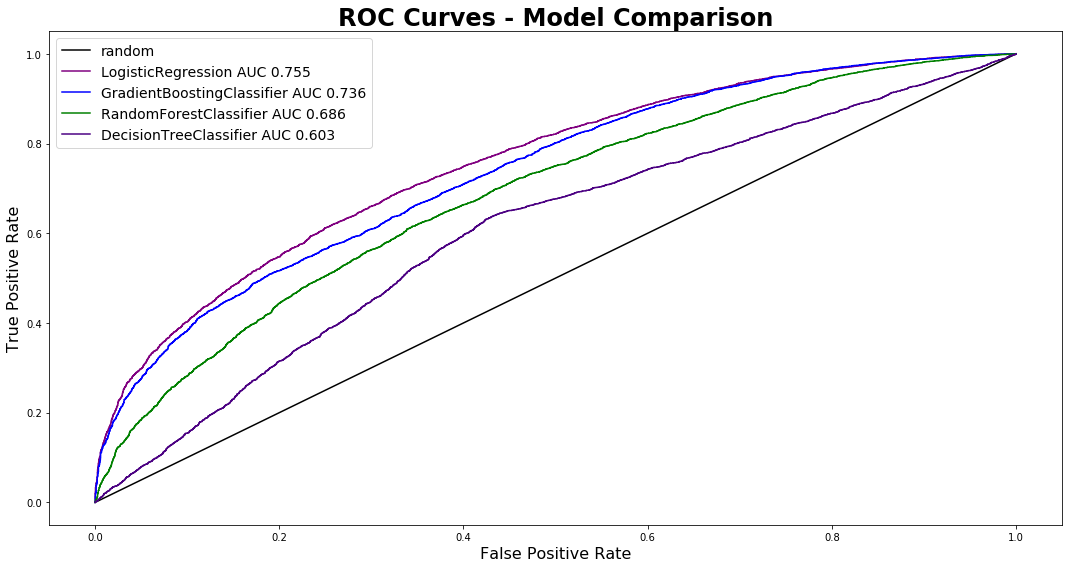

In [19]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('ROC Curves - Model Comparison', fontweight='bold', fontsize=24)


plt.gca().set_color_cycle(['purple', 'blue', 'green', 'indigo'])
plot_multiple_rocs(model_list, model3['review_text'], model3['skin_type'], TfidfVectorizer())
plt.tight_layout()
plt.savefig('imgs/model_compare_roc3.png')

## Latent Topics

In [22]:
latent_df = df[['review_text', 'skin_type']].copy()
latent_df = latent_df[(latent_df['skin_type'] == 'oily') | (latent_df['skin_type'] == 'dry')]
latent_df = cleaning(latent_df)
format_strings(latent_df, 'review_text', WordNetLemmatizer())

In [27]:
# vectorize, fit_transform
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(latent_df['review_text'])
idx_to_word = np.array(vectorizer.get_feature_names())
idx_to_word

array(['aa', 'aaaa', 'aaaaaaand', ..., 'zumba', 'zyrtec', 'zzone'],
      dtype='<U60')

In [ ]:
# find optimal number of topics

def fit_nmf(r):
    nmf = NMF(n_components=r)
    nmf.fit(X)
    W = nmf.transform(X)
    H = nmf.components_
    return nmf.reconstruction_err_

error = [fit_nmf(i) for i in range(1,1000)]
plt.plot(range(1,1000), error)
plt.xticks(range(1,1000))
plt.xlabel('Topics')
plt.ylabel('Reconstruction Error')

In [28]:
# apply NMF
nmf = NMF(n_components=10, solver='mu')
W = nmf.fit_transform(X)
H = nmf.components_

In [29]:
for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Topic 1: good,also,one,shade,im,would,skin,like,really,foundation
Topic 2: go,perfect,light,feel,amazing,finish,coverage,absolutely,foundation,love
Topic 3: year,favorite,far,one,tried,used,ive,foundation,ever,best
Topic 4: made,good,make,doesnt,work,cling,look,patch,skin,dry
Topic 5: looking,buildable,finish,good,light,foundation,medium,great,full,coverage
Topic 6: face,throughout,powder,matte,stay,last,hour,skin,day,oily
Topic 7: makeup,cakey,face,flawless,doesnt,feel,like,natural,make,look
Topic 8: amazing,coverage,recommend,testing,free,influenster,purpose,complimentary,received,product
Topic 9: look,perfectly,light,shade,tone,skin,color,perfect,match,great
Topic 10: beauty,blender,apply,way,long,brush,little,go,powder,use


### Check Coefficients and Feature Importance

In [132]:
# instantiate X and y for models
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(model2['review_text'])
y = model2['skin_type']

In [134]:
# fit and train, test, split model
model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [146]:
model.coef_

array([[-0.03503888,  0.05724623, -0.12674679, ...,  0.00768789,
         0.08477732, -0.32155908]])